<!-- This cell is automatically updated by tools/tutorial-cell-updater.py -->
<!-- The contents are initialized from tutorials/notebook-header.md -->

[<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>](https://colab.research.google.com/github/speechbrain/speechbrain/blob/develop/docs/tutorials/tasks/voice-activity-detection.ipynb)
to execute or view/download this notebook on
[GitHub](https://github.com/speechbrain/speechbrain/tree/develop/docs/tutorials/tasks/voice-activity-detection.ipynb)

# Voice Activity Detection

The goal of Voice Activity Detection (VAD) is to **detect** the **segments** containing **speech** within an audio recording.

As shown in the following picture, the input of a VAD is an audio signal (or its corresponding features). The output could be a sequence that is "1" for the time frames containing speech and "0" for non-speech frames.

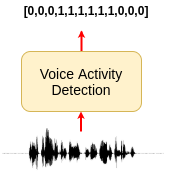

As an alternative, the VAD could provide in the output the **boundaries** where speech activity is detected. For instance:



```
segment_001  0.00  2.57 NON_SPEECH
segment_002  2.57  8.20 SPEECH
segment_003  8.20  9.10 NON_SPEECH
segment_004  9.10  10.93 SPEECH
segment_005  10.93  12.00 NON_SPEECH
segment_006  12.00  14.40 SPEECH
segment_007  14.40  15.00 NON_SPEECH
```


## What is VAD useful for?

A VAD plays a crucial role in many speech processing pipelines. It is used when we would like to apply the processing algorithms to the **speech parts** of the audio recording only.  

For instance, it is often employed as a **pre-processing step** for speech recognition, speech enhancement, speaker diarization, and many others systems.


## Why is challenging?

Discriminating speech from non-speech signals is very natural for humans. However, for a machine, this is much tricker. A good VAD should precisely detect speech activity even in **noisy** and **reverberant** conditions. The number of possible noise sources is huge in **real-life** conditions (e.g., music, telephone rings, alarms, etc.), making the problem challenging for a machine.

Moreover, a good VAD should be able to process both short and very **long recordings** (e.g., meetings) and, ideally, shouldn't be too computationally expensive.








## Pipeline description

Robust Voice Activity Detection has been a very active research field for decades. Today, deep learning plays a crucial role in this problem as well.

In this tutorial, we employ a neural network that provides speech/non-speech predictions for each input frame. The frame-level posterior probabilities are then post-processed to retrieve the final speech boundaries, as shown in the following figure:


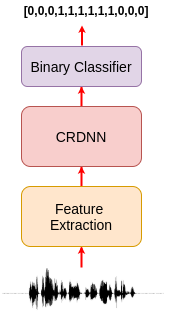

More precisely, we here compute the standard FBANK features and we plug them into a CRDNN model (which combines convolutional, recurrent, and fully connected layers). The output is processed with a **sigmoid** to perform a **binary classification**. The network is trained with **binary cross-entropy**. The predictions will be close to one for speech and close to zero for non-speech frames.

At inference time, the binary predictions are post-processed. For instance, we apply a **threshold** on them to identify the candidate speech regions. After that, we can apply other types of post-processing, such as merging segments that are close or remove segments that are too short. We will describe this in detail in the inference section.

Right now, let's briefly discuss how we can train such a model with SpeechBrain.

## Training
SpeechBrain has a recipe for training a VAD with the [LibriParty Dataset](https://www.dropbox.com/s/ebo987wu3hie3zm/LibriParty.tar.gz?e=1&st=bjjs0754&dl=1). This is a dataset that we created for tasks such a VAD training. It contains several simulated acoustic scenes with speech and noisy sequences periodically active (alone or simultaneously).

Beyond that, the training recipe creates **on-the-fly** several other **simulated acoustic scenes** using the Musan (that contains speech, noise, and music signals), CommonLanguage (that contains speech from 48 languages), and open-rir (that contains noise and impulse responses).

The acoustic scene simulated on the fly explores different scenarios such as noise + speech, speech to noise transitions, noise to speech transitions, etc.

Similarly to the other SpeechBrain recipes, one can train the model with the following commands:



```bash
cd recipes/LibriParty/VAD
python train.py hparams/train.yaml
```

Please, follow the README file available within the recipe and make sure you have downloaded all the data before starting the training.

Apart from the **massive use of speech augmentation/contamination**, the recipe has nothing special. Let's thus focus more on the inference part, which relies on some custom components.




## Inference

We can now focus on the inference part. The inference part is a bit more elaborated than usual because we designed it to work on very **long recordings** and to support several techniques for **post-processing** the network predictions.

We will address all of the aforementioned aspects. But, let's first install speechbrain:

In [1]:
%%capture
# Installing SpeechBrain via pip
BRANCH = 'develop'
!python -m pip install git+https://github.com/speechbrain/speechbrain.git@$BRANCH

In [2]:
%%capture
!wget -O /content/example_vad_music.wav "https://www.dropbox.com/scl/fi/vvffxbkkuv79g0d4c7so3/example_vad_music.wav?rlkey=q5m5wc6y9fsfvt43x5yy8ohrf&dl=1"

Let's read a speech signal:

<IPython.lib.display.Audio object>

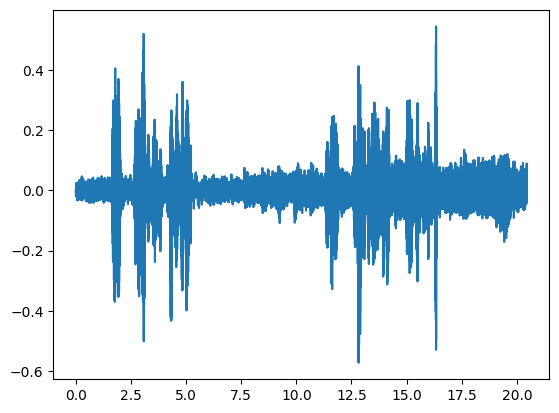

In [3]:
import torch
import torchaudio
import matplotlib.pyplot as plt

audio_file = "/content/example_vad_music.wav"
signal, fs = torchaudio.load(audio_file)
signal = signal.squeeze()
time = torch.linspace(0, signal.shape[0]/fs, steps=signal.shape[0])

plt.plot(time, signal)

from IPython.display import Audio
Audio(audio_file)

We can now use the VAD trained at the previous step in the following way:


In [4]:
from speechbrain.inference.VAD import VAD

VAD = VAD.from_hparams(source="speechbrain/vad-crdnn-libriparty", savedir="pretrained_models/vad-crdnn-libriparty")
boundaries = VAD.get_speech_segments(audio_file)
VAD.save_boundaries(boundaries)


hyperparams.yaml:   0%|          | 0.00/2.29k [00:00<?, ?B/s]

model.ckpt:   0%|          | 0.00/453k [00:00<?, ?B/s]

mean_var_norm.ckpt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

segment_001  0.00  0.23 NON_SPEECH
segment_002  0.23  5.58 SPEECH
segment_003  5.58  10.90 NON_SPEECH
segment_004  10.90  16.63 SPEECH


As you can see, the two speech parts are detected correctly. The music part is correctly classified as a non-speech segment, while the part where both music and speech are active is classified as speech.

## Inference Pipeline (Details)

The pipeline for detecting the speech segments is the following:

1. Compute **posteriors probabilities** at the frame level.
2. Apply a **threshold** on the posterior probability.
3. Derive candidate speech segments on top of that.
4. Apply **energy VAD** within each candidate segment (optional).
5. **Merge segments** that are too close.
6. **Remove segments** that are too short.
7. **Double-check speech** segments (optional).

To make debugging easier and the interface more **modular** and **transparent**, we allow users to access the output of these intermediate steps.

In some cases, these steps are not all needed. Users are free to customize the pipeline and its hyperparameters to improve the performance on their data.


Let's start with the posterior computation.

### 1- Posterior Computation
The neural model provides outputs that should be close to zero for non-speech frames and close 1 one from speech frames.

The time resolution depends on the **feature extraction** part and on the adopted neural **model**. In this case, we have a prediction every 10 ms (which is pretty standard for speech processing).

To compute the posterior probabilities, you can use the following command:

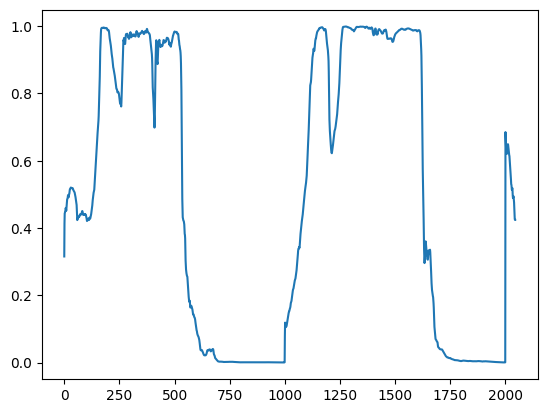

In [5]:
prob_chunks = VAD.get_speech_prob_file(audio_file)
plt.plot(prob_chunks.squeeze())

As expected, we have high values for speech regions and low values for the music one.

The `get_speech_prob_file function` is designed to process **long audio recordings**. It computes posterior probabilities on large chunks (e.g., 30 sec), that are read sequentially to avoid storing long signals in memory.
Each large chunk is, in turn, split into smaller ones (e.g., 10 seconds)
that are processed in parallel.

You can tune the `large_chunk_size` and `small_chunk_size` based on your memory constraints. If you have enough memory, you can use it to store a larger chunk of the signal (e.g., 5 minutes). This can be done by increasing `large_chunk_size` and will make the VAD (slightly) faster.



### 2- Apply a Threshold

Now, we can detect the candidate speech segments by applying a threshold.

To do it, you can use the following function:

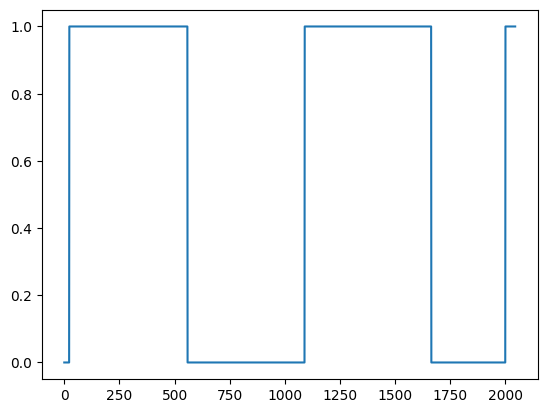

In [6]:
prob_th = VAD.apply_threshold(prob_chunks, activation_th=0.5, deactivation_th=0.25).float()
plt.plot(prob_th.squeeze())

Instead of applying a single threshold (e.g., 0.5),  we allow users to set two different thresholds, one to decide when to start a speech segment (`activation_th`) and one to detect when to stop it (`deactivation_th`).

According to our experience, it makes sense to set `activation_th` higher than than `deactivation_th` (e.g, `aactivation_th=0.5`, `deactivation_th=0.25`).

Users, however, can play with these hyperparameters to make the VAD more or less selective.


### 3- Get the Boundaries
Now, we can derive the boundaries of the speech segments from the thresholded posteriors:


In [7]:
boundaries = VAD.get_boundaries(prob_th)
VAD.save_boundaries(boundaries, audio_file=audio_file)

segment_001  0.00  0.23 NON_SPEECH
segment_002  0.23  5.58 SPEECH
segment_003  5.58  10.90 NON_SPEECH
segment_004  10.90  16.63 SPEECH
segment_005  16.63  20.00 NON_SPEECH
segment_006  20.00  20.43 SPEECH
segment_007  20.43  20.45 NON_SPEECH


The `boundaries` tensors contain the beginning and end second of each speech segment.
The method `save_boundaries` can be used to plot the boundaries in a human-readable format and/or to save them on a file (with the `save_path` argument).

### 4- Energy-based VAD (optional)

The trained neural VAD tends to detect large speech segments, where smaller speech segments that are close to each other are merged.

If the users want more resolution, one possible approach is to apply an **energy-based VAD** within the detected speech segments. The energy-based VAD processes the speech segments with sliding windows that compute the energy within each chunk.  The energy profile is normalized such that we have  0.5 and +-0.5 of standard deviation. We then apply a threshold and split the speech original segment into smaller ones.

This is done in the following way:

In [8]:
boundaries = VAD.energy_VAD(audio_file,boundaries, activation_th=0.8, deactivation_th=0.0)
VAD.save_boundaries(boundaries, audio_file=audio_file)

segment_001  0.00  1.66 NON_SPEECH
segment_002  1.66  2.13 SPEECH
segment_003  2.13  2.70 NON_SPEECH
segment_004  2.70  4.03 SPEECH
segment_005  4.03  4.27 NON_SPEECH
segment_006  4.27  5.26 SPEECH
segment_007  5.26  11.37 NON_SPEECH
segment_008  11.37  11.94 SPEECH
segment_009  11.94  12.63 NON_SPEECH
segment_010  12.63  13.12 SPEECH
segment_011  13.12  13.26 NON_SPEECH
segment_012  13.26  14.28 SPEECH
segment_013  14.28  14.99 NON_SPEECH
segment_014  14.99  15.67 SPEECH
segment_015  15.67  15.79 NON_SPEECH
segment_016  15.79  16.06 SPEECH
segment_017  16.06  16.30 NON_SPEECH
segment_018  16.30  16.42 SPEECH
segment_019  16.42  20.02 NON_SPEECH
segment_020  20.02  20.10 SPEECH
segment_021  20.10  20.18 NON_SPEECH
segment_022  20.18  20.18 SPEECH
segment_023  20.18  20.22 NON_SPEECH
segment_024  20.22  20.22 SPEECH
segment_025  20.22  20.29 NON_SPEECH
segment_026  20.29  20.35 SPEECH
segment_027  20.35  20.37 NON_SPEECH
segment_028  20.37  20.37 SPEECH
segment_029  20.37  20.42 NON_SPE

Users can have a more or less selective VAD by playing with `activation_th` and `deactivation_th`.

Differently from the neural VAD, the energy VAD tends to oversegment the input. We improve that by post-processing the boundaries, as will be shown below.

### 5- Merge close segments
The users might need to select the desired resolution for the VAD (the optimal level of granularity might depend on the task).

For instance, it could make sense to **merge segments** that are too close to each other.

This is done with the following method:

In [9]:
# 5- Merge segments that are too close
boundaries = VAD.merge_close_segments(boundaries, close_th=0.250)
VAD.save_boundaries(boundaries, audio_file=audio_file)


segment_001  0.00  1.66 NON_SPEECH
segment_002  1.66  2.13 SPEECH
segment_003  2.13  2.70 NON_SPEECH
segment_004  2.70  5.26 SPEECH
segment_005  5.26  11.37 NON_SPEECH
segment_006  11.37  11.94 SPEECH
segment_007  11.94  12.63 NON_SPEECH
segment_008  12.63  14.28 SPEECH
segment_009  14.28  14.99 NON_SPEECH
segment_010  14.99  16.42 SPEECH
segment_011  16.42  20.02 NON_SPEECH
segment_012  20.02  20.42 SPEECH
segment_013  20.42  20.45 NON_SPEECH


In this case, we merged segments that are closer than 250 ms. Users can play with `close_th` and tune it according to their needs.

### 6- Remove short segments
It could also make sense to remove short isolated segments that might be misclassified as speech:

In [10]:
# 6- Remove segments that are too short
boundaries = VAD.remove_short_segments(boundaries, len_th=0.250)
VAD.save_boundaries(boundaries, audio_file=audio_file)

segment_001  0.00  1.66 NON_SPEECH
segment_002  1.66  2.13 SPEECH
segment_003  2.13  2.70 NON_SPEECH
segment_004  2.70  5.26 SPEECH
segment_005  5.26  11.37 NON_SPEECH
segment_006  11.37  11.94 SPEECH
segment_007  11.94  12.63 NON_SPEECH
segment_008  12.63  14.28 SPEECH
segment_009  14.28  14.99 NON_SPEECH
segment_010  14.99  16.42 SPEECH
segment_011  16.42  20.02 NON_SPEECH
segment_012  20.02  20.42 SPEECH
segment_013  20.42  20.45 NON_SPEECH


In this case, we remove segments that are shorter than 250 ms. Note that we first merged segments that are close and only after we removed the short ones. This helps to remove short "isolated"  segments only.

### 7- Double check speech segments (optional)

At this point, we can take the post-processed speech segments and double-check if they really contain speech. This is done in this way:

In [11]:
# 7- Double-check speech segments (optional).
boundaries = VAD.double_check_speech_segments(boundaries, audio_file,  speech_th=0.5)
VAD.save_boundaries(boundaries, audio_file=audio_file)

segment_001  0.00  1.66 NON_SPEECH
segment_002  1.66  2.13 SPEECH
segment_003  2.13  2.70 NON_SPEECH
segment_004  2.70  5.26 SPEECH
segment_005  5.26  11.37 NON_SPEECH
segment_006  11.37  11.94 SPEECH
segment_007  11.94  12.63 NON_SPEECH
segment_008  12.63  14.28 SPEECH
segment_009  14.28  14.99 NON_SPEECH
segment_010  14.99  16.42 SPEECH
segment_011  16.42  20.45 NON_SPEECH


The method uses one more time the neural VAD on the detected speech segments. If the **average posterior probability within the segment** is larger than `speech_th` (in this case, `speech_th=0.5`), the speech segment is confirmed. Otherwise,  it is removed.



## Visualization

We also implemented some utilities to help users visualizing the output of the VAD:

In [12]:
upsampled_boundaries = VAD.upsample_boundaries(boundaries, audio_file)

This function creates a "VAD signal" with the **same dimensionality** as the original audio recording. This way, one can plot them jointly:

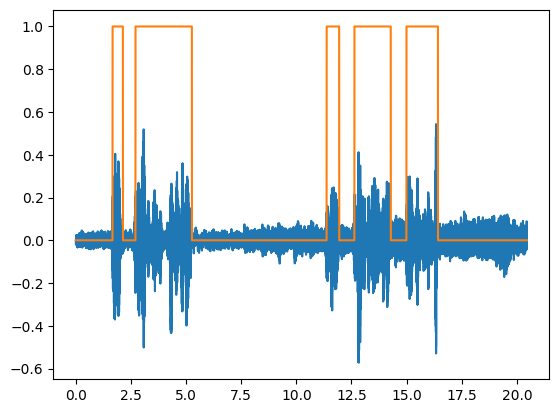

In [13]:
time = torch.linspace(0, signal.shape[0]/fs, steps=signal.shape[0])
plt.plot(time, signal)
plt.plot(time, upsampled_boundaries.squeeze())

For more details, one can also upsample and visualize VAD scores:

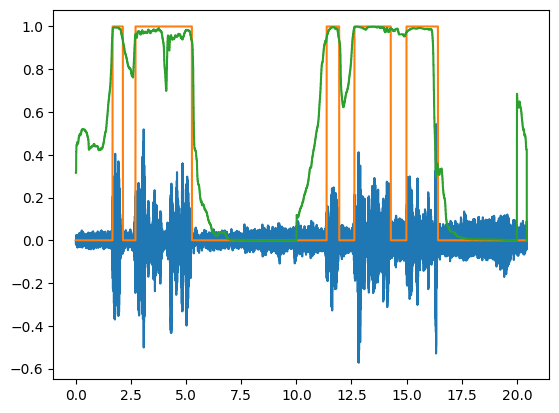

In [ ]:
upsampled_vad_scores = VAD.upsample_VAD(prob_chunks, audio_file)

plt.plot(time, signal)
plt.plot(time, upsampled_boundaries.squeeze())
plt.plot(time, upsampled_vad_scores.squeeze())

As an alternative, users can save the VAD file and open it with the original one using an audio visualization software like audacity.


**That's all! Happy VAD!**




---

## Appendix: on using energy-based VAD

If energy-based VAD is used, the order of the merge, remove, double-check operations matters. Let's use `double_check_speech_segments` right away after energy-based VAD and then `merge_close_segments`. Some speech frames are dropped:

In [ ]:
# plotted boundaries may be scaled down to compare many at once
def plot_boundaries(b, color):
  upsampled = VAD.upsample_boundaries(b, audio_file)
  plt.plot(time, upsampled.squeeze(), color)


# first figures - from CRDNN VAD to energy VAD
fig, axs = plt.subplots(3, 3, figsize=(16, 12))
plt.sca(axs[0, 0])
plt.title('1a. CRDNN VAD scores')
plt.plot(time, signal)

plt.plot(time, upsampled_vad_scores.squeeze(), 'green')

# CRDNN boundaries
plt.sca(axs[1, 0])
plt.title('1b. CRDNN VAD boundaries')
plt.plot(time, signal)

boundaries = VAD.get_boundaries(prob_th)
plot_boundaries(boundaries, 'orange')

# energy VAD boundaries
plt.sca(axs[2, 0])
plt.title('1c. Energy VAD boundaries based on CRDNN')
plt.plot(time, signal)

boundaries_energy = VAD.energy_VAD(audio_file, boundaries, activation_th=0.8, deactivation_th=0.0)
plot_boundaries(boundaries_energy, 'purple')

# second figure - double-check, then merge
plt.sca(axs[0, 1])
plt.title('2a. Energy VAD (same as 1c)')
plt.plot(time, signal)

plot_boundaries(boundaries_energy, 'purple')

# double-check
plt.sca(axs[1, 1])
plt.title('2b. Double-check (too early)')
plt.plot(time, signal)

boundaries = VAD.double_check_speech_segments(boundaries_energy, audio_file,  speech_th=0.5)
plot_boundaries(boundaries, 'red')

# merge (too late)
plt.sca(axs[2, 1])
plt.title('2c. Merge short segments (too late)')
plt.plot(time, signal)

boundaries = VAD.merge_close_segments(boundaries, close_th=0.250)
plot_boundaries(boundaries, 'black')

# third figure - merge, remove, double-check
plt.sca(axs[0, 2])
plt.title('3a. Energy VAD (same as 1c)')
plt.plot(time, signal)

plot_boundaries(boundaries_energy, 'purple')

# merge
plt.sca(axs[1, 2])
plt.title('3b. Merge short segments (as above)')
plt.plot(time, signal)

boundaries = VAD.merge_close_segments(boundaries_energy, close_th=0.250)
plot_boundaries(boundaries, 'black')

# merge
plt.sca(axs[2, 2])
plt.title('3c. Remove short segments & double-check (as above)')
plt.plot(time, signal)

boundaries = VAD.remove_short_segments(boundaries, len_th=0.250)
boundaries = VAD.double_check_speech_segments(boundaries, audio_file,  speech_th=0.5)
plot_boundaries(boundaries, 'red')

Exception ignored in: <function _xla_gc_callback at 0x7f3035dbd750>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


## Citing SpeechBrain

If you use SpeechBrain in your research or business, please cite it using the following BibTeX entry:

```bibtex
@misc{speechbrainV1,
  title={Open-Source Conversational AI with {SpeechBrain} 1.0},
  author={Mirco Ravanelli and Titouan Parcollet and Adel Moumen and Sylvain de Langen and Cem Subakan and Peter Plantinga and Yingzhi Wang and Pooneh Mousavi and Luca Della Libera and Artem Ploujnikov and Francesco Paissan and Davide Borra and Salah Zaiem and Zeyu Zhao and Shucong Zhang and Georgios Karakasidis and Sung-Lin Yeh and Pierre Champion and Aku Rouhe and Rudolf Braun and Florian Mai and Juan Zuluaga-Gomez and Seyed Mahed Mousavi and Andreas Nautsch and Xuechen Liu and Sangeet Sagar and Jarod Duret and Salima Mdhaffar and Gaelle Laperriere and Mickael Rouvier and Renato De Mori and Yannick Esteve},
  year={2024},
  eprint={2407.00463},
  archivePrefix={arXiv},
  primaryClass={cs.LG},
  url={https://arxiv.org/abs/2407.00463},
}
@misc{speechbrain,
  title={{SpeechBrain}: A General-Purpose Speech Toolkit},
  author={Mirco Ravanelli and Titouan Parcollet and Peter Plantinga and Aku Rouhe and Samuele Cornell and Loren Lugosch and Cem Subakan and Nauman Dawalatabad and Abdelwahab Heba and Jianyuan Zhong and Ju-Chieh Chou and Sung-Lin Yeh and Szu-Wei Fu and Chien-Feng Liao and Elena Rastorgueva and François Grondin and William Aris and Hwidong Na and Yan Gao and Renato De Mori and Yoshua Bengio},
  year={2021},
  eprint={2106.04624},
  archivePrefix={arXiv},
  primaryClass={eess.AS},
  note={arXiv:2106.04624}
}
```